In [2]:
# Source tutos : https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

import torch
import torchaudio
import numpy as np

import torchaudio.functional as F
import torchaudio.transforms as T

import math
import timeit
import librosa
import resampy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from IPython.display import Audio, displays
from torchaudio.utils import download_asset

# import OS module
import os

#plt.close('all')

#-----------------------------Fonctions Helper - Uniquement affichage
#Pour le mod�le train, on ne devrait avoir besoin que de l'affichage des formes d'onde au fil des epoch

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

#-----Afficher les formes d'onde en torchaudio
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

  #-----Pour les spectros en STFT
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)
  
  #-----Pour les spectro de Mel
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

#-----Play audio....
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")
#-----Plot Mel filter bank
def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)
  
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#------------------------------------Mes Fonctions

def resampling(waveform, sample_rate, resample_rate):
    resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype,lowpass_filter_width=128,rolloff=0.99, resampling_method="kaiser_window")
    resampled_waveform = resampler(waveform)
    return resampled_waveform

def transfo(SAMPLE_WAV_PATH,n_fft,resample_rate,temps_sig,maxi=1.25):
    #-------------------------Ouverture d'un fichier et affichage spectro/waveform
    
    #metadata = torchaudio.info(SAMPLE_WAV_PATH)
    #print(metadata)
    waveform, sample_rate = torchaudio.load(SAMPLE_WAV_PATH)
    waveform=waveform/(maxi*0.8)
    #print_stats(waveform, sample_rate=sample_rate)
    # plot_waveform(waveform, sample_rate)
    #plot_specgram(waveform, sample_rate)
    #play_audio(waveform, sample_rate)
    
    #-----------------------Conversion de Sr
    
    resampled_waveform=resampling(waveform,sample_rate,resample_rate)
    
    #-----------------------D�coupe du signal resampl� � la bonne dur�e
    dur1=len(resampled_waveform[0])
    #print(resample_rate)
    durVoulue=int(temps_sig*resample_rate)
    #print(dur1,durVoulue)
    #print(resampled_waveform.shape)
    if durVoulue<=dur1:
        resampled_waveform=resampled_waveform[:durVoulue]
        #print(1)
        #print(resampled_waveform.shape)
    else:
        #print(2)
        resampled_waveform=torch.cat((resampled_waveform,torch.zeros(1,durVoulue-dur1)),dim=1)
        #print(resampled_waveform.shape)
    #plot_specgram(resampled_waveform, resample_rate)
    #plot_waveform(resampled_waveform, resample_rate)
    
    
    
    #----------------------Spectro de Mel
    #hop_length = 512
    #win_length = 990
    n_mels = 128
    
    transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        #win_length=win_length,
        #hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm='slaney',
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
        )
    melspec = transform(resampled_waveform)  # (channel, n_mels, time)
    #plot_spectrogram(
    #    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')
    return melspec

def getmax(path):
    dir_list = os.listdir(path)
    maxi=0
    for i in range(1,len(dir_list)):
        SAMPLE_WAV_PATH=dir_list[i]
        waveform, sample_rate = torchaudio.load(path+"/"+SAMPLE_WAV_PATH)
        abso=abs(waveform).numpy()
        max1=np.amax(abso[0])
        maxi=max(maxi,max1)
    return maxi




#-----------------------Reconstruction par Griffin-Lim
def recons(melspec,n_fft,resample_rate,maxi):
    melspec=melspec*(maxi*0.8)

    inverse_melscale_transform = T.InverseMelScale(n_stft=n_fft // 2 + 1) #On repasse en STFT pour Griffin-Lim
    rev_spec = inverse_melscale_transform(melspec)
    
    griffin_lim = T.GriffinLim(#D�claration de Griffin-Lim
        n_fft=n_fft,
        #win_length=win_length,
        #hop_length=hop_length,
    )
    waveform_r = griffin_lim(rev_spec)#On applique Griffin-Lim
    
    plot_waveform(waveform_r, resample_rate, title="Reconstructed")
    return waveform_r
    
    
    
    
#-----------------------DataLoader complet
def dataloader(path,temps_sig,resample_rate,n_fft):
    dir_list = os.listdir(path)
    maxi=0
    melspecs=[]
    for i in range(1,len(dir_list)):
        SAMPLE_WAV_PATH=dir_list[i]
        
        #Uniquement si max sur la waveform
        #maxi=getmax(path)
        #print(i)
        melspec=transfo(path+"/"+SAMPLE_WAV_PATH,n_fft,resample_rate,temps_sig,maxi=1.25)
        melspecs.append(melspec) #i-1 sur mon PC, pas sur le dataload
        
        #Uniquement si max sur le Mel Spectro
        abso=abs(melspec.numpy())
        max1=np.amax(abso[0])
        maxi=max(maxi,max1)
    #melspecs2=np.empty(i,dtype=object)
    for u in melspecs:
        u=u.clone().detach().requires_grad_(True)/(maxi*0.8)
        
    return melspecs,maxi

Files and directories in ' /home/pierre/OneDrive/ATIAM/UE - IM/Conditional-audio-synthesis-using-adversarial-networks/data/percussion ' :
['sbonogroll.wav', 'ltimbales.wav', 'maracasskinroll.wav', 'brakedrum2.wav', 'striangle.wav', 'fingercym.wav', 'templeblock1.wav', 'mdbrush.wav', 'tomtom8.wav', 'tambshake.wav', 'mshit.wav', 'tympC2.wav', 'ltriangle.wav', 'woodblock2.wav', 'congaopen.wav', 'chingong2.wav', 'cuica3.wav', 'tympE2.wav', 'woodblock1.wav', 'mdhit.wav', 'sdcrossstick.wav', 'agogo1.wav', 'castanethit.wav', 'ltimbalesrs.wav', 'waterphone1.wav', 'mdroll.wav', 'stimbales.wav', 'sdbrushroll.wav', 'sdbrush.wav', 'cuicaslide.wav', 'marktreel2h.wav', 'largegong.wav', 'cencerros3.wav', 'mdhitinverse.wav', 'tambroll.wav', 'cencerros2.wav', 'templeblock2.wav', 'orchcym.wav', 'msbrushroll.wav', 'sdhitinverse.wav', 'mscrossstick.wav', 'lbongohit.wav', 'turkcym15.wav', 'alpenglock2.wav', 'mshitinverse.wav', 'logdrum3.wav', 'bamboochimeshit.wav', 'alpenglock3.wav', 'chingong1.wav', 'ratc

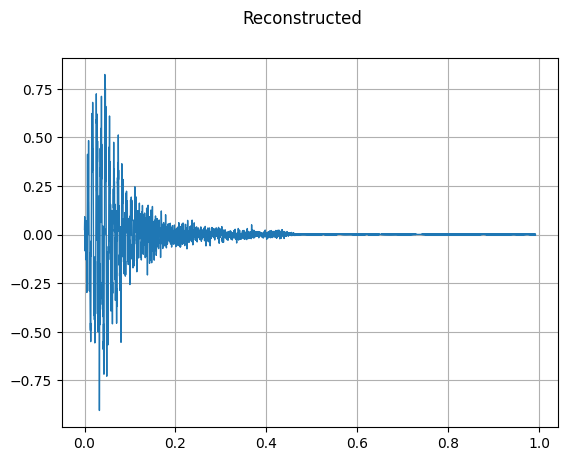

In [3]:
#-----------------------------------------------------------Code

# Get the list of all files and directories
# path = "C:/Users/GaHoo/Desktop/Cours/ATIAM/2. Informatique/Projet/data/percussion"
path = "/home/pierre/OneDrive/ATIAM/UE - IM/Conditional-audio-synthesis-using-adversarial-networks/data/percussion"
dir_list = os.listdir(path)
print("Files and directories in '", path, "' :")
# prints all files
print(dir_list)


#SAMPLE_WAV_PATH = "data/percussion/agogo1.wav"
resample_rate = 16000
n_fft = 1024
temps_sig = 1

dataset, maxi = dataloader(path,temps_sig,resample_rate,n_fft)

signal = recons(dataset[0],n_fft,resample_rate,maxi)

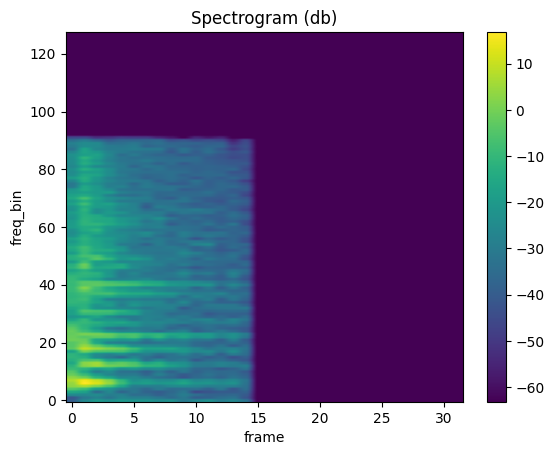

In [4]:
plot_spectrogram(dataset[0][0].numpy(), title=None, ylabel='freq_bin', aspect='auto', xmax=None)

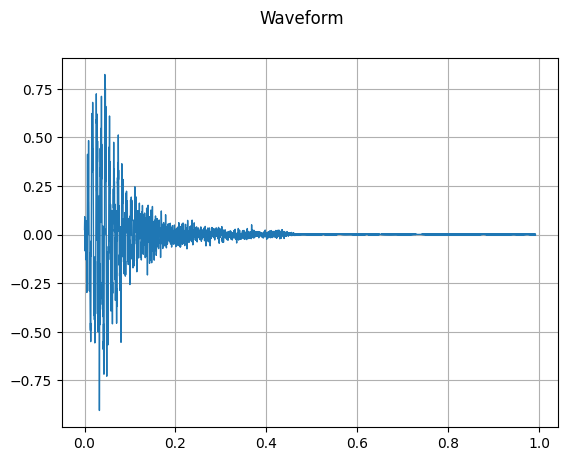

In [5]:
plot_waveform(signal, resample_rate, title="Waveform", xlim=None, ylim=None)

In [6]:
play_audio(signal, resample_rate)

### Test à part

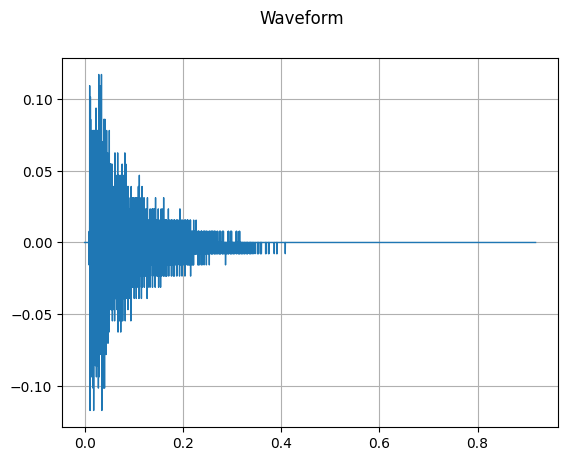

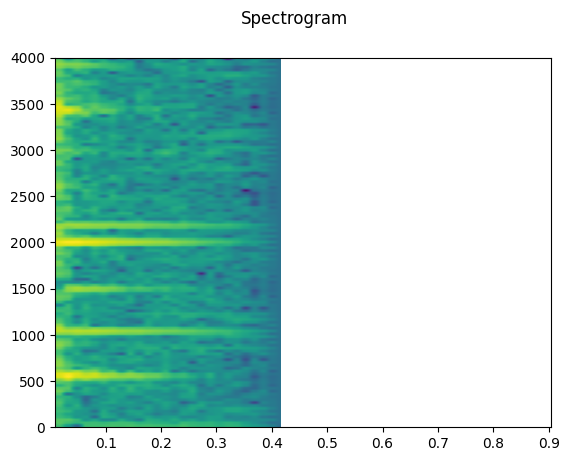

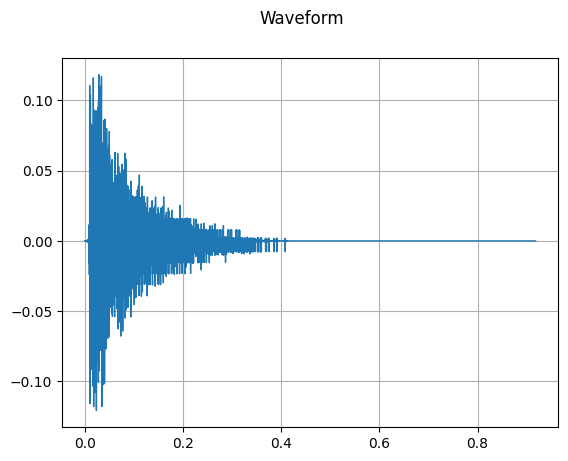

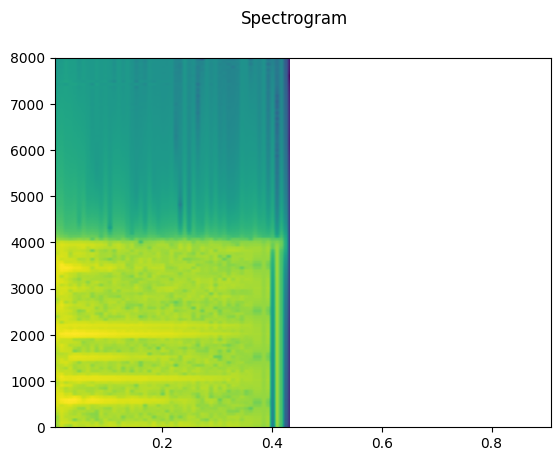

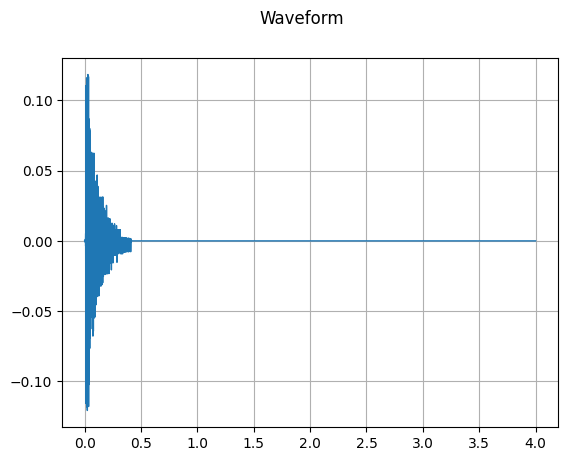

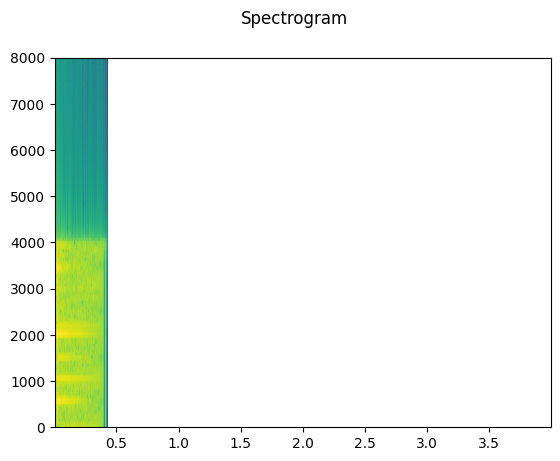

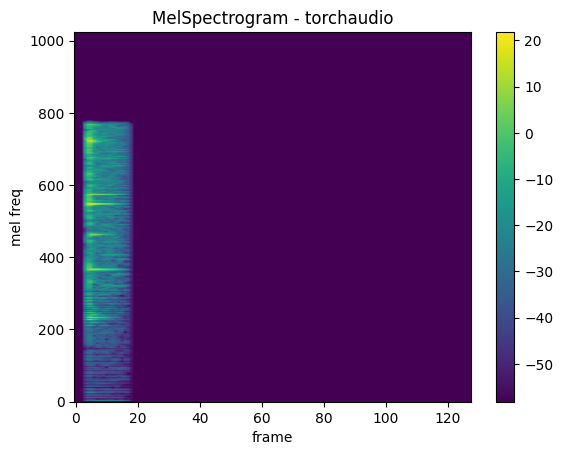

In [11]:
waveform, sample_rate = torchaudio.load('./agogo1.wav')
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

#-----------------------Conversion de Sr

resampled_waveform = resampling(waveform , sample_rate, 16000)
plot_waveform(resampled_waveform, 16000)
plot_specgram(resampled_waveform, 16000)
play_audio(resampled_waveform, 16000)


temps_sig = 4
#-----------------------D�coupe du signal resampl� � la bonne dur�e
dur1 = len(resampled_waveform[0])
durVoulue = int(temps_sig*resample_rate)
if durVoulue<=dur1:
    resampled_waveform=resampled_waveform[:durVoulue]
else:
    resampled_waveform=torch.cat((resampled_waveform,torch.zeros(1,durVoulue-dur1)),dim=1)


plot_waveform(resampled_waveform, 16000)
plot_specgram(resampled_waveform, 16000)
play_audio(resampled_waveform, 16000)


#----------------------Spectro de Mel
time_steps, n_mels = 128, 1024   
frame_length = n_mels * 2
hop_length = int((1.0 - 0.75) * frame_length)
num_samples = hop_length * (time_steps - 1) + frame_length

transform = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=frame_length,
    hop_length=hop_length,
    win_length=frame_length,
    center=False,
    power=2.0,
    n_mels=n_mels,
)

resampled_waveform = torch.nn.functional.pad(resampled_waveform, ((num_samples - len(resampled_waveform[0]), 0)), "constant", 0)

melspec = transform(resampled_waveform)  # (channel, n_mels, time)
plot_spectrogram(
   melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')


melspec_log = torch.log(1 + melspec)

maxi = torch.max(torch.abs(melspec_log))

melspec_log_norm = (melspec_log / (maxi / (2 * 0.8))) - 0.8


In [12]:
torch.min(melspec_log_norm), torch.max(melspec_log_norm)

(tensor(-0.8000), tensor(0.8000))

/home/pierre/anaconda3/envs/projet_ml/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (1024) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


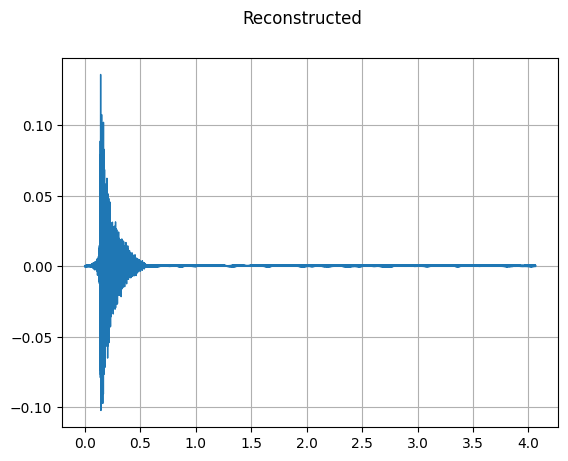

In [14]:
melspec_log = (melspec_log_norm + 0.8) * (maxi / (2 * 0.8))

inv_melspec = torch.exp(melspec_log) - 1

inverse_melscale_transform = T.InverseMelScale(n_stft=frame_length // 2 + 1, 
                                               n_mels=n_mels,
                                               sample_rate = 16000,
                                               )
rev_spec = inverse_melscale_transform(inv_melspec)

griffin_lim = T.GriffinLim(
    n_fft=frame_length,
    n_iter=100,
    hop_length=hop_length,
    win_length=frame_length,
)
waveform_r = griffin_lim(rev_spec)

plot_waveform(waveform_r, resample_rate, title="Reconstructed")

In [15]:
play_audio(waveform_r, 16000)